In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from hidmed import *
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [3]:
n = 5000
udim = 1
xdim = 5
zdim = 2
wdim = 2
mdim = 2
datagen = LinearHidMedDataset(xdim, zdim, wdim, mdim, udim, setup="a")


def sweep_hyperparameters(
    n,
    setup,
    nonnegative=True,
    azwy_nonnegative=False,
    seed=0,
    n_xfit=5,
    n_max=10000,
    maxfev=100,
    gamma_h=None,
    gamma_q=None,
):
    datagen = LinearHidMedDataset(
        xdim,
        zdim,
        wdim,
        mdim,
        udim,
        setup=setup,
        nonnegative=nonnegative,
        azwy_nonnegative=azwy_nonnegative,
        seed=seed,
    )
    data = datagen.sample_dataset(n_max, seed=0)
    if n_xfit == -1:
        data = HidMedDataset(
            data.get_X(np.arange(2 * n)),
            data.get_U(np.arange(2 * n)),
            data.get_A(np.arange(2 * n)),
            data.get_M(np.arange(2 * n)),
            data.get_W(np.arange(2 * n)),
            data.get_Z(np.arange(2 * n)),
            data.get_Y(np.arange(2 * n)),
        )

        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )
        lambdas_h = est.optimize_lambdas("h", 1, 2, maxfev=maxfev, grid_search=True)
        lambdas_q = est.optimize_lambdas("q", 1, 2, maxfev=maxfev, grid_search=True)
    else:
        data = HidMedDataset(
            data.get_X(np.arange(n)),
            data.get_U(np.arange(n)),
            data.get_A(np.arange(n)),
            data.get_M(np.arange(n)),
            data.get_W(np.arange(n)),
            data.get_Z(np.arange(n)),
            data.get_Y(np.arange(n)),
        )
        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )
        lambdas_h = est.optimize_lambdas(
            "h", 1, n_xfit, maxfev=maxfev, grid_search=True
        )
        lambdas_q = est.optimize_lambdas(
            "q", 1, n_xfit, maxfev=maxfev, grid_search=True
        )
    return lambdas_h, lambdas_q


def run(
    n,
    runs,
    setup,
    lambdas_h,
    lambdas_q,
    alpha,
    gamma_dr,
    nonnegative=True,
    azwy_nonnegative=False,
    seed=0,
    n_xfit=5,
    n_max=10000,
    gamma_h=None,
    gamma_q=None,
):
    datagen = LinearHidMedDataset(
        xdim,
        zdim,
        wdim,
        mdim,
        udim,
        setup=setup,
        nonnegative=nonnegative,
        azwy_nonnegative=azwy_nonnegative,
        seed=seed,
    )

    # ground truth
    true_psi = datagen.true_psi(n=100000)

    coverage_h = 0.0
    coverage_q = 0.0
    coverage_d = 0.0

    ci_h = 0.0
    ci_q = 0.0
    ci_d = 0.0

    bias_h = 0.0
    bias_q = 0.0
    bias_d = 0.0

    var_h = 0.0
    var_q = 0.0
    var_d = 0.0

    mse_h = 0.0
    mse_q = 0.0
    mse_d = 0.0

    psi_est_h = []
    psi_est_q = []
    psi_est_d = []
    for i in tqdm(range(runs)):
        data = datagen.sample_dataset(n_max, seed=seed + i + 1)

        if lambdas_h is None or lambdas_q is None:
            data_tuning = HidMedDataset(
                data.get_X(np.arange(2 * n)),
                data.get_U(np.arange(2 * n)),
                data.get_A(np.arange(2 * n)),
                data.get_M(np.arange(2 * n)),
                data.get_W(np.arange(2 * n)),
                data.get_Z(np.arange(2 * n)),
                data.get_Y(np.arange(2 * n)),
            )
            est_tuning = ProximalHidMedRKHS(
                data_tuning,
                create_kernel(n_jobs=5, gamma=gamma_h),
                create_kernel(n_jobs=5, gamma=gamma_q),
            )
            lambdas_h = est_tuning.optimize_lambdas(
                "h", 1, 2, maxfev=25, grid_search=True
            )
            lambdas_q = est_tuning.optimize_lambdas(
                "q", 1, 2, maxfev=25, grid_search=True
            )

        data = HidMedDataset(
            data.get_X(np.arange(n)),
            data.get_U(np.arange(n)),
            data.get_A(np.arange(n)),
            data.get_M(np.arange(n)),
            data.get_W(np.arange(n)),
            data.get_Z(np.arange(n)),
            data.get_Y(np.arange(n)),
        )
        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )

        psi1_h = est.plugin_h(
            lambdas_h,
            1.0,
            None,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )
        psi1_q = est.plugin_q(
            lambdas_q,
            alpha,
            gamma_q,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )
        psi1_d = est.double_robust(
            lambdas_h,
            lambdas_q,
            alpha,
            gamma_dr,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )

        psi_est_h.append(np.mean(psi1_h))
        psi_est_q.append(np.mean(psi1_q))
        psi_est_d.append(np.mean(psi1_d))

        coverage_h += is_covered(psi1_h, true_psi) / runs
        coverage_q += is_covered(psi1_q, true_psi) / runs
        coverage_d += is_covered(psi1_d, true_psi) / runs

        bias_h += (np.mean(psi1_h) - true_psi) / runs
        bias_q += (np.mean(psi1_q) - true_psi) / runs
        bias_d += (np.mean(psi1_d) - true_psi) / runs

        var_h += np.var(psi1_h) / runs
        var_q += np.var(psi1_q) / runs
        var_d += np.var(psi1_d) / runs

        mse_h += calculate_mse(psi1_h, true_psi) / runs
        mse_q += calculate_mse(psi1_q, true_psi) / runs
        mse_d += calculate_mse(psi1_d, true_psi) / runs

        ci_h += 2 * (1.96 * np.std(psi1_h) / np.sqrt(len(psi1_h))) / runs
        ci_q += 2 * (1.96 * np.std(psi1_q) / np.sqrt(len(psi1_q))) / runs
        ci_d += 2 * (1.96 * np.std(psi1_d) / np.sqrt(len(psi1_d))) / runs

    return {
        "psi_est_h": psi_est_h,
        "psi_est_q": psi_est_q,
        "psi_est_d": psi_est_d,
        "true": true_psi,
        "coverage_h": coverage_h,
        "coverage_q": coverage_q,
        "coverage_d": coverage_d,
        "mse_h": mse_h,
        "mse_q": mse_q,
        "mse_d": mse_d,
        "bias_h": bias_h,
        "bias_q": bias_q,
        "bias_d": bias_d,
        "var_h": var_h,
        "var_q": var_q,
        "var_d": var_d,
        "ci_h": ci_h,
        "ci_q": ci_q,
        "ci_d": ci_d,
    }

# sweep sample sizes

In [4]:
seed = 2
n_xfit = 2
num_runs = 10

sample_sizes = [2000, 3000, 4000]

if n_xfit > 0:
    sample_sizes = [int(s * n_xfit / (n_xfit - 1)) for s in sample_sizes]

gammas = {
    ("a", "h"): np.array([2e-3, 2e-3, 2e-3]),  # np.array([5e-5, 5e-5, 5e-5]),
    ("a", "q"): np.array([5e-3, 5e-3, 5e-3]),  # np.array([1e-2, 1e-2, 1e-2]),
    ("b", "h"): np.array([5e-2, 5e-2, 5e-2]),  # np.array([4e-4, 4e-4, 4e-4]),
    ("b", "q"): np.array([1e-2, 5e-3, 5e-3]),  # np.array([1e-2, 1e-2, 1e-2]),
    ("c", "h"): np.array([5e-2, 5e-2, 5e-2]),
    ("c", "q"): np.array([1e-2, 5e-3, 5e-3]),
}
alphas = {"a": [200, 200, 200], "b": [5000, 5000, 5000], "c": [5000, 5000, 5000]}
gamma_drs = {
    "a": [50 * 1e-3, 50 * 1e-3, 50 * 1e-3],
    "b": [100 * 1e-3, 100 * 1e-3, 100 * 1e-3],
    "c": [1e-3 * 100, 1e-3 * 100, 1e-3 * 100],
}
results = {}
for setup in ["a", "b", "c"]:
    n_fit = sample_sizes[0]
    lambdas_h, lambdas_q = sweep_hyperparameters(
        n_fit,
        setup,
        seed=seed,
        n_xfit=n_xfit,
        maxfev=100,
        gamma_h=gammas[(setup, "h")][0],
        gamma_q=gammas[(setup, "q")][0],
    )
    lambdas_h_scale = lambdas_h * n_fit**0.8
    lambdas_q_scale = lambdas_q * n_fit**0.8
    for i in range(len(sample_sizes)):
        n = sample_sizes[i]

        lambdas_h = lambdas_h_scale / n**0.8
        lambdas_q = lambdas_q_scale / n**0.8

        results[n, setup] = run(
            n,
            num_runs,
            setup,
            lambdas_h,
            lambdas_q,
            alphas[setup][i],
            gamma_drs[setup][i],
            n_xfit=n_xfit,
            gamma_h=gammas[(setup, "h")][i],
            gamma_q=gammas[(setup, "q")][i],
            seed=seed,
        )

        abs_norm_bias_h = (
            np.abs(results[n, setup]["bias_h"]) / results[n, setup]["true"]
        )
        abs_norm_bias_q = (
            np.abs(results[n, setup]["bias_q"]) / results[n, setup]["true"]
        )
        abs_norm_bias_d = (
            np.abs(results[n, setup]["bias_d"]) / results[n, setup]["true"]
        )

        print(setup, n)
        print(lambdas_h, lambdas_q, alphas[setup][i], gamma_drs[setup][i])
        print(
            "coverages:",
            results[n, setup]["coverage_h"],
            results[n, setup]["coverage_q"],
            results[n, setup]["coverage_d"],
        )
        print(
            "length:",
            results[n, setup]["ci_h"],
            results[n, setup]["ci_q"],
            results[n, setup]["ci_d"],
        )
        print(
            "MSEs:",
            results[n, setup]["mse_h"],
            results[n, setup]["mse_q"],
            results[n, setup]["mse_d"],
        )
        print("anb: ", abs_norm_bias_h, abs_norm_bias_q, abs_norm_bias_d)
        print("true: ", results[n, setup]["true"])

100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


a 4000
[8.21734572e-07 2.28652526e-01] [1.37073588e-07 1.37073588e-07] 200 0.05
coverages: 0.1 0.0 0.9999999999999999
length: 0.42119707136222534 0.025835582587003924 2.400732912466531
MSEs: 0.18446191657585065 8.658608379173794 1.1152478180158027
anb:  0.19589264498382705 1.426524328293821 0.010841295681943627
true:  2.0


100%|██████████| 10/10 [02:14<00:00, 13.43s/it]


a 6000
[5.94098631e-07 1.65311473e-01] [9.91016246e-08 9.91016246e-08] 200 0.05
coverages: 0.0 0.0 0.9999999999999999
length: 0.36084787928155515 0.02973439694408549 1.3525494709686041
MSEs: 0.16382035463167943 9.52137895296063 0.22546039864103332
anb:  0.19276656978685672 1.5232390976018186 0.05580072230995113
true:  2.0


100%|██████████| 10/10 [04:36<00:00, 27.66s/it]


a 8000
[4.71962576e-07 1.31326390e-01] [7.87281026e-08 7.87281026e-08] 200 0.05
coverages: 0.0 0.0 0.9999999999999999
length: 0.32195201903509435 0.0277945441443388 1.1538287183132643
MSEs: 0.15812185406007354 10.851563237431758 0.13839494666683252
anb:  0.1899658424516123 1.6352891404107517 0.019857257745768603
true:  2.0


100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


b 4000
[4.92616934e-06 2.28652526e-01] [1.37073588e-07 1.77037347e-04] 5000 0.1
coverages: 0.0 0.7999999999999999 0.8999999999999999
length: 0.23457480905505546 1.165106101393366 1.3112232125984846
MSEs: 0.24900095779837517 0.22265729831927766 0.26495063674674546
anb:  0.21849287848775933 0.014021588751886797 0.03444033973464684
true:  2.23501662216739


100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


b 6000
[3.56152773e-06 1.65311473e-01] [9.91016246e-08 1.27994670e-04] 5000 0.1
coverages: 0.0 0.7 0.7999999999999999
length: 0.2005224815801653 0.8425867786601795 1.0225751948766872
MSEs: 0.18677689584065302 0.18505093891723748 0.15058107143890642
anb:  0.1891671025606845 0.060353360909381835 0.06497682804917122
true:  2.238860767854089


100%|██████████| 10/10 [04:46<00:00, 28.68s/it]


b 8000
[2.82934131e-06 1.31326390e-01] [7.87281026e-08 1.01681255e-04] 5000 0.1
coverages: 0.0 0.8999999999999999 0.8999999999999999
length: 0.17540684934794662 0.7542444369704271 0.9133705628505933
MSEs: 0.1631558561500365 0.11545779585122452 0.11242832688780227
anb:  0.17684486785883172 0.04720048463319965 0.05593311219798653
true:  2.246762200445462


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


c 4000
[4.92616934e-06 2.28652526e-01] [1.37073588e-07 1.77037347e-04] 5000 0.1
coverages: 0.0 0.8999999999999999 0.8999999999999999
length: 0.25989634240724935 1.3479679031071043 1.459362467123868
MSEs: 0.3415220677336397 0.35318870225997523 0.3262317063925356
anb:  0.17573925704302068 0.08997945023167059 0.0339499746309356
true:  3.258918194835477


100%|██████████| 10/10 [02:16<00:00, 13.68s/it]


c 6000
[3.56152773e-06 1.65311473e-01] [9.91016246e-08 1.27994670e-04] 5000 0.1
coverages: 0.0 0.5 0.7999999999999999
length: 0.22184820260629096 0.9824088353104143 1.1346502076458453
MSEs: 0.22688877764256812 0.4340049901477143 0.18015524078399991
anb:  0.14447491994121753 0.1477367696251032 0.047945040464775726
true:  3.2359051052697785


100%|██████████| 10/10 [04:45<00:00, 28.52s/it]

c 8000
[2.82934131e-06 1.31326390e-01] [7.87281026e-08 1.01681255e-04] 5000 0.1
coverages: 0.0 0.30000000000000004 0.9999999999999999
length: 0.19458992881727358 0.8811873237484789 1.0095877497697336
MSEs: 0.18899359998184018 0.3166203154905747 0.1343709071828851
anb:  0.13213175488409462 0.1330792791020917 0.040013822928504306
true:  3.2345529979389647


In [6]:
import pickle

pickle.dump(results, open("assets/prox_hidmed_ndim_results.pkl", "wb"))

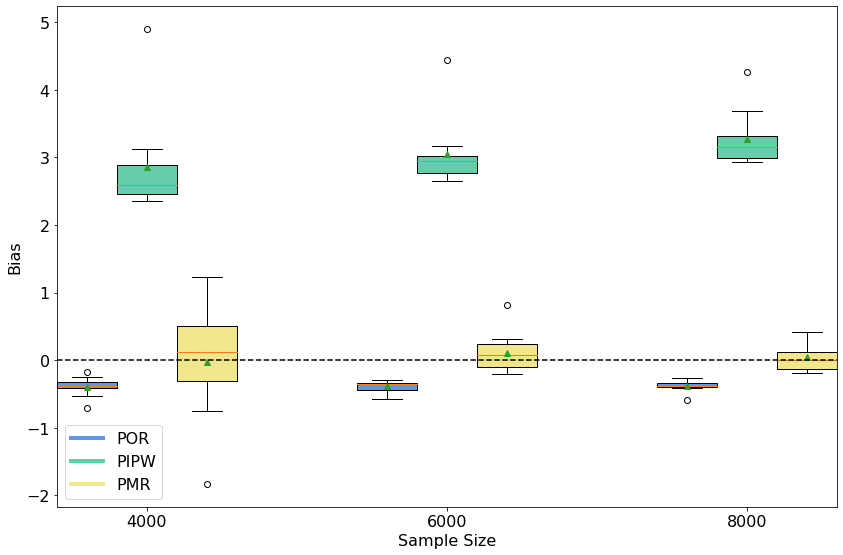

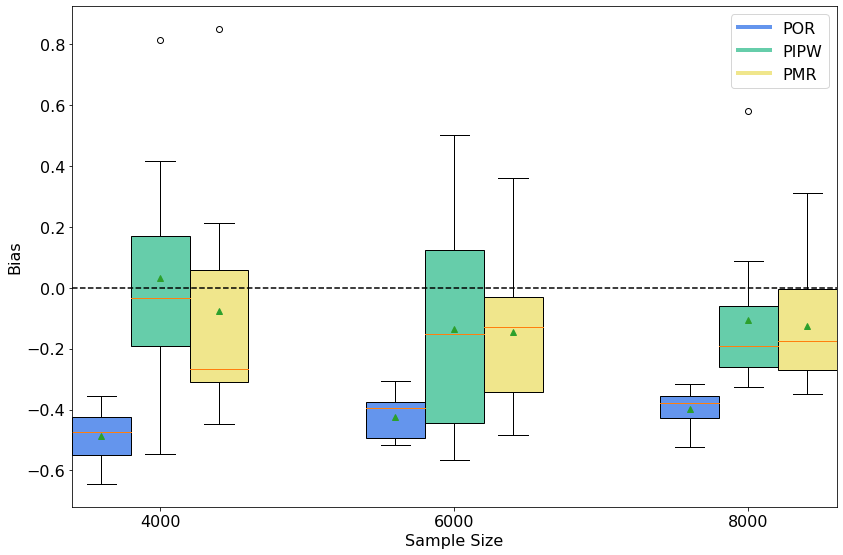

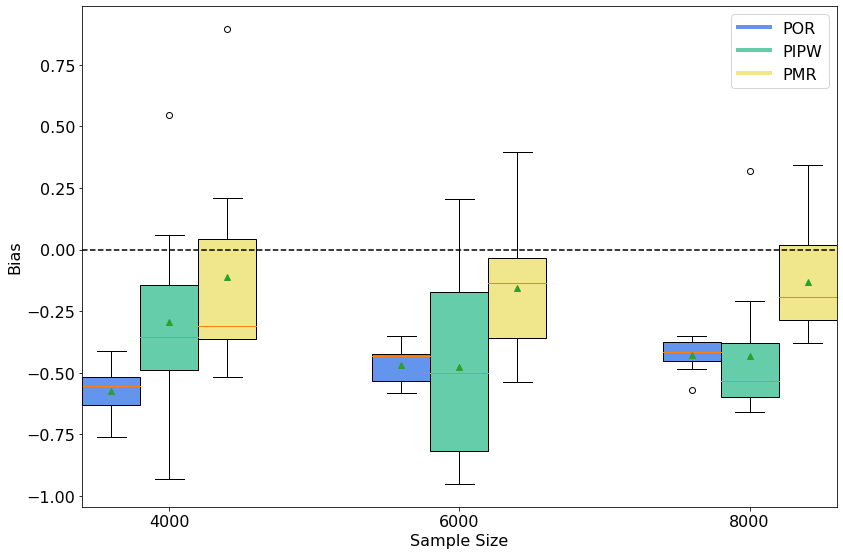

In [8]:
import matplotlib
from matplotlib.lines import Line2D


keys = ["psi_est_h", "psi_est_q", "psi_est_d"]
font = {"size": 16}
matplotlib.rc("font", **font)

for mode in ["a", "b", "c"]:
    idx = 1
    positions = []
    for col in range(len(sample_sizes)):
        for i in range(len(keys)):
            positions.append(idx)
            idx += 1
        idx += 2

    labels = [
        sample_sizes[col] if i == 2 else " "
        for col in range(len(sample_sizes))
        for i in range(3)
    ]

    fig, ax = plt.subplots(figsize=(2 * 3 * 2, 4 * 2))
    plotdata = []
    for n in sample_sizes:
        for key in keys:
            plotdata.append(np.array(results[n, mode][key]) - results[n, mode]["true"])

    bplot = ax.boxplot(
        np.vstack(plotdata).T,
        positions=positions,
        labels=labels,
        patch_artist=True,
        widths=1,
        showmeans=True,
    )

    base_colors = ["cornflowerblue", "mediumaquamarine", "khaki"]
    colors = [c for _ in range(len(sample_sizes)) for c in base_colors]
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in base_colors]
    ax.legend(custom_lines, ["POR", "PIPW", "PMR"])

    ax.axhline(y=0.0, color="k", linestyle="--", zorder=3)
    # plt.ylim(-7.1, 7.1)
    plt.xticks(positions[1 :: len(keys)], sample_sizes)
    plt.xlabel("Sample Size")
    plt.ylabel("Bias")
    plt.tight_layout()
    plt.savefig(
        "assets/prox_hidmed_nd_sample_sizes_setup_%s_2fold_xfit.png" % mode, dpi=500
    )
    plt.show()